In [1]:
!pip install keras #install keras for GPU IBM AI lab 

#Sebastian Zdarowski CSC 578 NN 
# Video Link: https://drive.google.com/open?id=1nqZUQWcjFSpQ4gCvLOQS5tPp_T0bgpMm

    100% |################################| 317kB 30.4MB/s 
    100% |################################| 51kB 24.1MB/s 
    100% |################################| 51kB 23.9MB/s 
You are using pip version 18.0, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Install Keras for IBM Labs 

In [2]:
import keras; print(keras.__version__) 

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


2.2.4


Objective:The task of the competition is to predict the temperature at the next hour given the weather conditions and temperature for prior hours. 

This is a multivariate timeseries forecasting problem, and we use a neural network approach to tackle the problem as our ML method. 

We will be using the following tools: 
-Pandas
-Numpy
-Keras 
-Mapplotlib to help us with EDA analysis
-Sklearn for pre processing 
- An LSTM model to predict the temps 


Contents are as followed: 

- Load Data/setup of notebook
- Exploratory Analysis 
- Pre processing 
- Model Building 
- Prediction outputs 

Load data/Setup of Notebook:

In [3]:
#import tools 
import pandas as pd
import numpy as np
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler #for Zscore 

# settings
import warnings
warnings.filterwarnings("ignore")

Import the datasets for testing and training 

In this dataset, 14 different quantities (including air temperature, atmospheric pressure and humidity) The original data goes back to 2003, but we are using a subset for this competition, from 2009 to 2016 (both inclusive). The temperature measurements are per hour.


In [4]:
#lets load in our data 
climate_train = pd.read_csv("climate_hour_train.csv", header=0)
climate_test = pd.read_csv("climate_Xtest2.csv",header=None)
#climate_test was giving issues with column order, switched deg c in test file with column mbar so that dec is first in row of 14
#Was messing with the predictions, I was prediciting mbar before column order switch


Exploreatory data analysis:
    

In [5]:
climate_train.dtypes
#check what data types we are working with

Date Time           object
p (mbar)           float64
T (degC)           float64
Tpot (K)           float64
Tdew (degC)        float64
rh (%)             float64
VPmax (mbar)       float64
VPact (mbar)       float64
VPdef (mbar)       float64
sh (g/kg)          float64
H2OC (mmol/mol)    float64
rho (g/m**3)       float64
wv (m/s)           float64
max. wv (m/s)      float64
wd (deg)           float64
dtype: object

In [6]:
climate_train.head() #show first 5 rows of training dataset 15 columns 1st column being date time 
#climate_test.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
1,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
3,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
4,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [7]:
climate_train.describe(include='all') #show desriptive stats of each variable ignore date time before pre processing 

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,52566,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000
unique,52566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,12.12.2011 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,988.723002,9.172795,283.254265,4.779049,76.444300,13.357483,9.458133,3.899249,5.977212,9.568031,1216.718989,2.142170,3.539017,173.689628
std,NaN,8.190684,8.533081,8.605048,6.922701,16.430164,7.572008,4.201679,4.723265,2.666892,4.253017,40.439912,1.530832,2.313246,87.251111
min,NaN,918.500000,-22.760000,250.850000,-24.800000,13.060000,0.970000,0.810000,0.000000,0.510000,0.810000,1066.190000,0.000000,0.000000,0.000000
25%,NaN,983.750000,3.110000,277.242500,0.130000,65.810000,7.640000,6.170000,0.810000,3.890000,6.240000,1188.082500,1.010000,1.800000,120.800000
50%,NaN,989.140000,9.310000,283.430000,5.200000,79.700000,11.740000,8.850000,2.090000,5.595000,8.965000,1213.440000,1.790000,3.000000,197.100000
75%,NaN,994.070000,15.280000,289.370000,10.030000,89.800000,17.390000,12.320000,5.130000,7.780000,12.450000,1243.050000,2.880000,4.750000,233.800000


Lets look at the basic stats of the variables within the training set. 

1. For temp in Deg C we see that the average temp is 9.17 C 

Highest point for temp C was 
35.48 which occurs on July 19th 2012 

Lowest point for temp C was 
-22.76 degrees which occurs on Jan 7th 2009 

 - Temp C Has a std deviation of 8.53 

 
-Data set also provides us Kalvin temps, and other metrics associated with temp

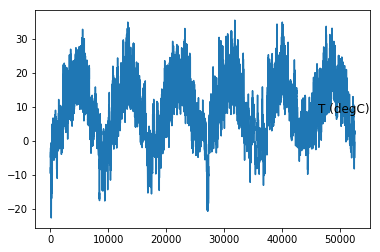

In [8]:
#Lets look at the temp C over time 

#chart time series variables
values = climate_train.values
# specify columns to plot
groups = [2] #capture all 14 features 
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(climate_train.columns[group], y=.5, loc='right')
    i += 1
pyplot.show() #output charts 


- We see seasonal patterns with Temp, Highs most likely occuring during summer months, and lows during Winter

Clean the data: 

Remove the time stamp as its not needed for this project 

In [9]:
dateTime = climate_train["Date Time"] #Identify date time 
dateTime.head() #check and see if loaded properly 

climate_train.drop('Date Time', axis=1, inplace=True)
# Remove date time from train dataset 


In [10]:
#place temp column first as we want to predict temp C 
cols = list(climate_train) #get list of columns
cols.insert(0, cols.pop(cols.index('T (degC)')))
climate_train = climate_train.ix[:, cols]
climate_train.head()

,T (degC),p (mbar),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,-8.05,996.50,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
1,-8.88,996.62,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2,-8.81,996.84,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
3,-9.05,996.99,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
4,-9.63,997.46,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [380]:
#climate_train.head() #just checking to see if date time was removed 
#climate_train.shape

(52566, 14)

Time series plots 

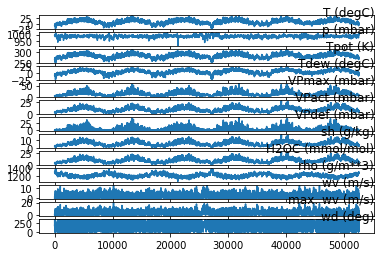

In [11]:
#chart time series variables
values = climate_train.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7,8,9,10,11,12,13] #capture all 14 features 
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(climate_train.columns[group], y=.5, loc='right')
    i += 1
pyplot.show() #output charts 

Variables within the timeset seem to be following a wave pattern.
- This seems to be true across all the variables
- Most likely indicating a seasonal pattern 

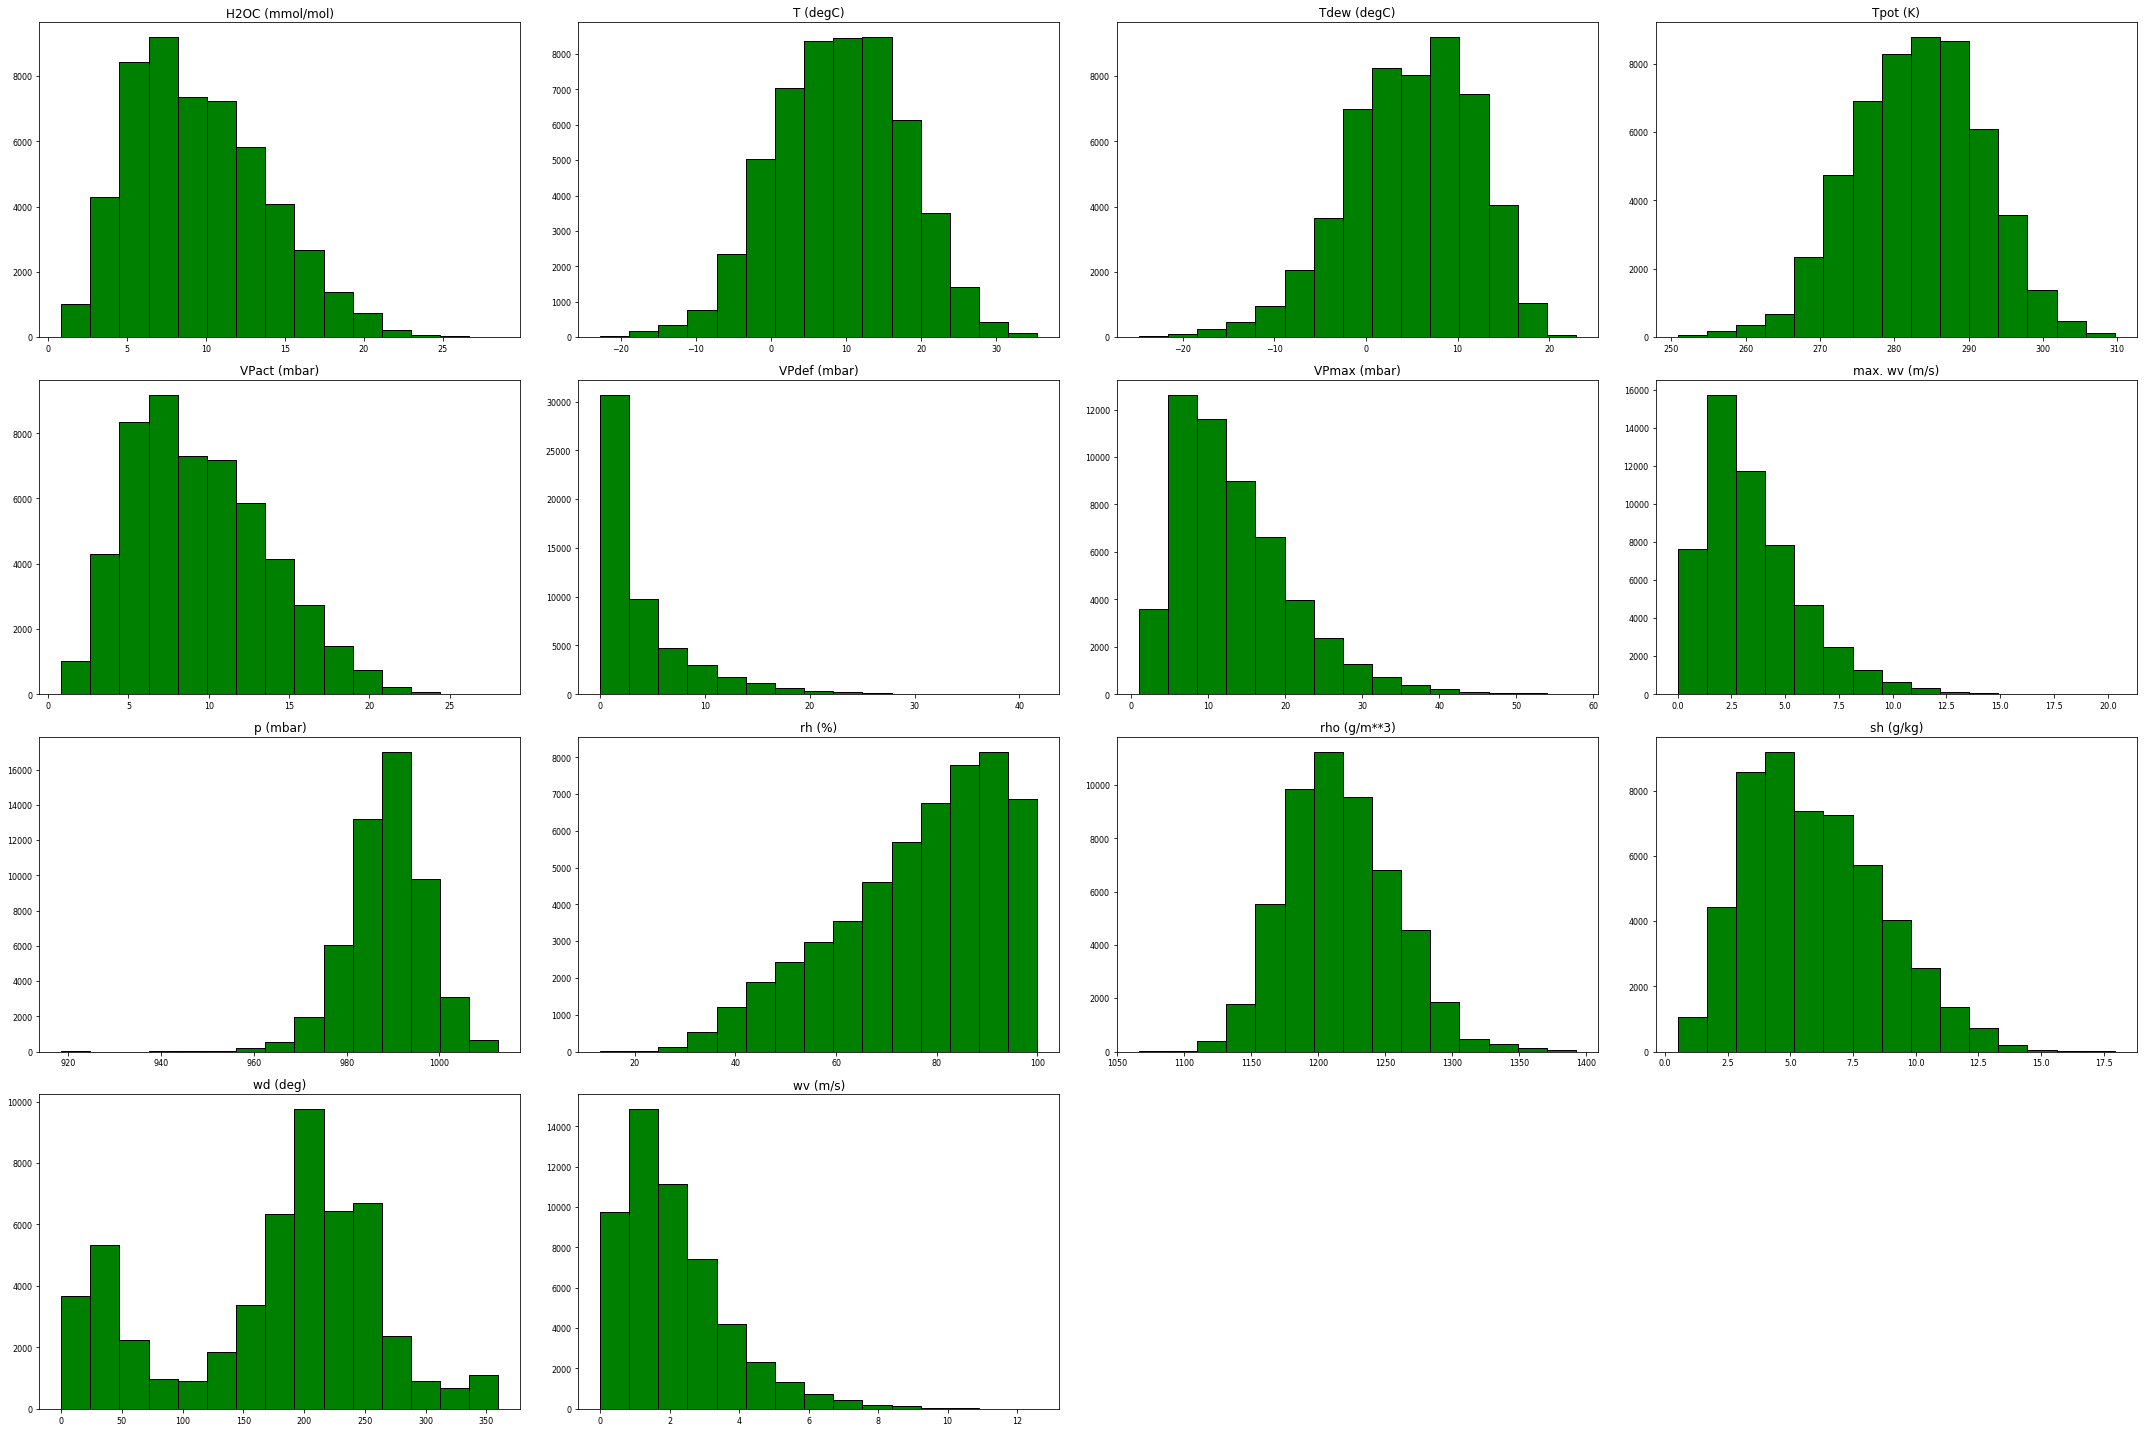

In [302]:
climate_train.hist(bins=15, color='green', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
pyplot.tight_layout(rect=(0, 0, 5, 5))

Seems we have slight normal distribution with the target variable Temp C 
Temp C and Temp In K share same distrubtion, which makes sense since they are just different calculations of temp

From a few of these histograms we can infer that there is some right skewness in the following variables:
-rh(%)
-Vpdef
-max vs wv
-wv(m/s)
-sh(g/kg)


End of EDA 

Start Preprocessing:

Clean data and convert to numpys

In [12]:
climate_train.head() #just checking to see if date time was removed 
climate_train.shape

(52566, 14)

In [13]:
climate_train = climate_train.values #convert from pandas to numpy array

In [14]:
climate_train #show array 

array([[-8.05000e+00,  9.96500e+02,  2.65380e+02, ...,  2.10000e-01,
         6.30000e-01,  1.92700e+02],
       [-8.88000e+00,  9.96620e+02,  2.64540e+02, ...,  2.50000e-01,
         6.30000e-01,  1.90300e+02],
       [-8.81000e+00,  9.96840e+02,  2.64590e+02, ...,  1.80000e-01,
         6.30000e-01,  1.67200e+02],
       ...,
       [ 1.96000e+00,  1.00669e+03,  2.74600e+02, ...,  6.70000e-01,
         1.56000e+00,  1.45300e+02],
       [ 1.94000e+00,  1.00692e+03,  2.74560e+02, ...,  7.10000e-01,
         1.80000e+00,  1.29600e+02],
       [ 2.18000e+00,  1.00711e+03,  2.74780e+02, ...,  3.50000e-01,
         8.60000e-01,  1.40800e+02]])

In [15]:
from sklearn import preprocessing

# integer encode direction
encoder = preprocessing.LabelEncoder()
climate_train[:,13] = encoder.fit_transform(climate_train[:,13])

In [16]:
climate_train = climate_train.astype('float32') #convert to float 32 

Normalize the training dataset with the orginal 14 data columns 

The standard score of a sample x is calculated as:

z = (x - u) / s
where u is the mean of the training samples and s is the standard deviation of the training samples
 Standard Scaler will be able to normalize our dataset with Z scores 


In [17]:
# normalize dataset training 
scaler = StandardScaler()
trans_climate_train = scaler.fit_transform(climate_train)
#trans_climate_train = pd.DataFrame(trans_climate_train)

#print(scaler.mean_) # mean of each column
print(scaler.transform(climate_train))

#some notes from sklearn to figure out transformations 
#trans_climate_train = scaler.transform(climate_train)
# inverse_transform(self, X[, copy])	Scale back the data to the original representation
#scaled = scaler.fit_transform(series.values)

#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

[[-2.018375    0.9495071  -2.0772     ... -1.2621825  -1.2575595
   0.36840418]
 [-2.1156447   0.9641574  -2.1748176  ... -1.2360526  -1.2575595
   0.3554438 ]
 [-2.1074412   0.99102134 -2.1690083  ... -1.2817798  -1.2575595
   0.23070014]
 ...
 [-0.8452824   2.1936157  -1.0057256  ... -0.9616893  -0.8555232
   0.11243667]
 [-0.8476262   2.2216942  -1.0103751  ... -0.9355595  -0.7517719
   0.02765419]
 [-0.8195001   2.2448916  -0.9848083  ... -1.1707281  -1.1581311
   0.08813596]]


In [18]:
trans_climate_train.shape #check shape of transformed data 
#trans_climate_train.view() #view transfomred data 

(52566, 14)

Now we are going to normalize the test set as well

In [19]:
# normalize dataset used for testing 
#scalerTest = StandardScaler()
print(scaler.fit(climate_test)) #z score sclaing 

#print(scalerTest.mean_) # mean of each column
print(scaler.transform(climate_test))
trans_climate_test = scaler.transform(climate_test)

StandardScaler(copy=True, with_mean=True, with_std=True)
[[-1.02505876e+00  1.90341581e+00 -1.17392800e+00 ...  2.07820107e-02
   2.23714948e-02 -2.47042174e-01]
 [-1.00507785e+00  1.88843350e+00 -1.15301957e+00 ...  1.80368908e-02
   2.07868659e-02 -2.45860357e-01]
 [-1.02755638e+00  1.93107546e+00 -1.17884764e+00 ...  5.15007824e-03
   9.62843806e-03 -5.05859994e-01]
 ...
 [-1.61074917e+00  2.10394830e+00 -1.76551380e+00 ...  1.79493177e-03
   1.70529399e-03  3.40320642e-01]
 [-1.65445741e+00  2.09127096e+00 -1.80733068e+00 ...  4.11052077e-05
  -3.31269725e-03 -2.01563061e+00]
 [-1.79307497e+00  2.07398367e+00 -1.94139066e+00 ...  3.93002498e-03
   5.16822384e-04  5.31774920e-01]]


In [20]:
trans_climate_test.shape

(17447, 336)

Now that we have normalized both our training and test sets we need to set up the training data set 
into time series data format 
prepare the training data to be Keras RNN/-ready.  Our forecasting scheme is to look back 24 hours (e.g. h1 through h24) and predict the next hour (h25).  And we use all 14 climate measurements of the previous 24 hours to predict the temperature (only) of the 24th hour (thus just one feature)

In [21]:
# Create time series data for training
#With this function we will be able to shape our train set to become keras ready 

# convert series to supervised learning
def setup(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    #if dropnan:
      #  agg.dropna(inplace=True)
    return agg


In [22]:
values = trans_climate_train

In [23]:
values.view() #view our arrary 

values = values.astype('float32') #convert values in float 32

-Since we have 24 hours to predict our window size will be 24

-Our features that we are going to include will be 14. Set those into variables to use for pre procesing and re formatting later

In [24]:
# specify the number of  hours
n_hours = 24
n_features = 14 #We have 14 features that need to be included 
# frame as supervised learning
reframed = setup(values, n_hours, 1) #run the function to convert our training set to be keras ready 

In [25]:
reframed.shape

(52566, 350)

In [26]:
reframed.dropna(axis=0, inplace=True) #drop any n/a in the model 
reframed.shape #check shape

(52542, 350)

In [27]:
values = reframed.values
n_train_hours = 52542
train = values[:n_train_hours, :]

# split into input and outputs
n_obs = n_hours * n_features # Get proper number of observations 
train_X, train_y = train[:, :n_obs], train[:, -n_features] #create train x and y 
test_X = trans_climate_test[:, :n_obs] #set up prediction fi
print(train_X.shape, len(train_X), train_y.shape)

(52542, 336) 52542 (52542,)


In [28]:
print(test_X.shape, len(test_X))
#check shape

(17447, 336) 17447


In [29]:
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features)) #set up 3D for LTSM model
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape) #check shapes and verify that its 3D

(52542, 24, 14) (52542,) (17447, 24, 14)


Model Building: 
Now we are going to Build our LTSM Neural Network 

In [141]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(300,input_shape =(train_X.shape[1],train_X.shape[2]),return_sequences = True))
model.add(LSTM(64)) #add on addtioanl 64 nodes 
model.add(Dropout(0.25)) #add drop out layer
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss="mae", optimizer="adam") #USE MAE as instructed 
model.summary()
#not great kaggle score using this model, obtain 1.22, lets try a simpler model 
#drop out and addtional layers, did not provide optimal scores. 
# Model seems to float around .08 error rate when ran.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 24, 300)           378000    
_________________________________________________________________
lstm_14 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 471,505
Trainable params: 471,505
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Define the LSTM model
#2nd Model less layers, more nodes simple model 
model = Sequential()
model.add(LSTM(230,input_shape =(train_X.shape[1],train_X.shape[2])))
model.add(Dense(1))
model.compile(loss="mae", optimizer="adam")
model.summary()
#first model had 31 nodes tried 50
#second model had 240 nodes tried, 50, 100
#3rd model will have 300 nodes tried, 50, 100 and 75 epochs
#4th model go to 250 nodes, and try 60 epochs
#5th Attempt will have 230 nodes, do 60 epochs 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 230)               225400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 231       
Total params: 225,631
Trainable params: 225,631
Non-trainable params: 0
_________________________________________________________________


In [33]:
# fit model & track run time
start = time.time() 
history = model.fit(train_X,train_y,batch_size=240,epochs=60,shuffle=False) #turn shuffle off so that we dont mess with date settings 
print("> Compilation Time : ", time.time() - start) #Gather time it took to complete the model 


Epoch 1/60
52542/52542 [==============================] - 15s 281us/step - loss: 0.1660
Epoch 2/60
52542/52542 [==============================] - 13s 245us/step - loss: 0.0792
Epoch 3/60
52542/52542 [==============================] - 13s 243us/step - loss: 0.0671
Epoch 4/60
52542/52542 [==============================] - 13s 243us/step - loss: 0.0621
Epoch 5/60
52542/52542 [==============================] - 13s 241us/step - loss: 0.0645
Epoch 6/60
52542/52542 [==============================] - 13s 246us/step - loss: 0.0634
Epoch 7/60
52542/52542 [==============================] - 13s 246us/step - loss: 0.0648
Epoch 8/60
52542/52542 [==============================] - 13s 243us/step - loss: 0.0652
Epoch 9/60
52542/52542 [==============================] - 13s 250us/step - loss: 0.0592
Epoch 10/60
52542/52542 [==============================] - 13s 244us/step - loss: 0.0600
Epoch 11/60
52542/52542 [==============================] - 13s 248us/step - loss: 0.0621
Epoch 12/60
52542/52542 [=====

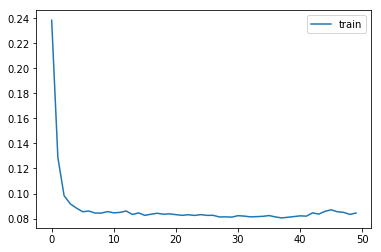

In [143]:
# plot history of training set of model with 300 nodes and 50 epochs , batch size 240 
# seems that around 65-75 epochs would of been best, after 80 model was jumping around with loss score 
pyplot.plot(history.history['loss'], label='train')
#This model scored .90 on Kaggle 
pyplot.legend()
pyplot.show()

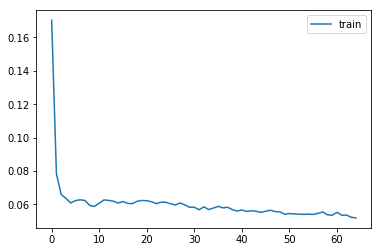

In [157]:
# plot history of training set of model with 300 nodes and 100 epochs , batch size 240 
# seems that around 65-75 epochs would of been best, after 80 model was jumping around with loss score 
#This model scored .90 on Kaggle 
pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()
#this model scored. 56!! on kaggle 

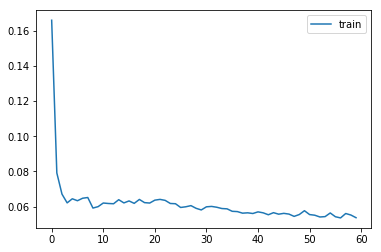

In [34]:
# plot history of training set of model with 300 nodes and 100 epochs , batch size 240 
# seems that around 65-75 epochs would of been best, after 80 model was jumping around with loss score 
#This model scored .90 on Kaggle 
pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()
#this model scored. 52!! on kaggle 

What does the chart tell us? 
- With a simpler LTSM model we were able to obtain our best score. 
- We see above that the training test set, was able to learn quickly 
- With a simpler model, we are able to start off with a loss of .16 compared to a more complex model starting at .24 
   - Also with a simpler model, we are able to obtain a loss of <.06 compared to our more complex model than converged around .08


Predictions/ Output Predictions file:

In [35]:
# make a forecast predication
predictions = model.predict(test_X)#, batch_size=1)

In [36]:
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

In [162]:
predictions.shape #check the shape of our input file to kaggle 

(17447, 1)

In [147]:
test_X.shape


(17447, 336)

In [31]:
trans_climate_train.shape

(52566, 14)

In [37]:
#invert scaling for predictions file 

trans_preds = np.concatenate((predictions, test_X[:, -13:]), axis=1)
#trans_preds = scaler.inverse_transform(trans_preds)
trans_preds = trans_preds[:,0]

In [38]:
trans_preds

array([-1.08740473, -1.03363407, -1.05297971, ..., -1.75666046,
       -1.64641893, -1.81283164])

In [39]:
trans_preds.shape[0]
#lengh = trans_preds.shape[0]
#print(lengh)

#trans_preds[0]

17447

In [40]:
for x in range(trans_preds.shape[0]):
    trans_preds[x] = ((trans_preds[x] * 8.01432) + 10.25075) #do manual scaling to reverse temp per professors guidelines
    
trans_preds   

array([ 1.53594054,  1.96687583,  1.81183367, ..., -3.82768907,
       -2.94417815, -4.27786287])

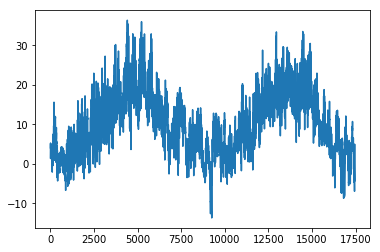

In [41]:
pyplot.plot(trans_preds)

What do we see with our prediction results? 
 - We are seeing seasonal trends with out temp C, which indicates a good sign. The training data set went over a few years, while the prediction only went 2 years. So we should be seeing this trend here. 

Lets get the file ready to be submitted to Kaggle 

In [42]:
#Export PDF to predictions and submit to kaggle
predictionsCSV = pd.read_csv('sample_submission_2019spring.csv', header=0, index_col=0)
predictionsCSV['temperature']=trans_preds #Place our values for temp in prediction file 
predictionsCSV.to_csv('predictions.csv')


#End of code 